# Simple transformation: double permutation

Write simple transformation in onnx, in this case a tranposition

**Reference**

For more information see:

`plot_onnx_operators.ipynb`

copied from

https://xadupre.github.io/skl2onnx/auto_examples/plot_onnx_operators.html

**List of onnx operation**

Full list of operations can be found at|

https://xadupre.github.io/skl2onnx/onnx_ops.html

In [1]:
# Base for the types
import numpy as np

# Elementary mathematical functions
from skl2onnx.algebra.onnx_ops import OnnxTranspose

# Onnx back function
import onnx
from onnx import ModelProto
import onnxruntime as rt

# Plot graph
import pydot
from IPython.display import Image
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer

# Create new transformation

In [2]:
# 1. Input shape
# from doc: np.arrays are good enough to define the input shape
X = np.arange(2 * 3 * 4).reshape((2, 3, 4)).astype(np.float32)

# 2. Transformation
node = OnnxTranspose(OnnxTranspose('X', perm=[1, 0, 2]), perm=[1, 0, 2])
model_custom = node.to_onnx({'X': X})

# 3. Check if model is OK
onnx.checker.check_model(model_custom)

# 4. Save transfo
onnx_file = "custom_transpose.onnx"
with open(onnx_file, "wb") as f:
    f.write(model_custom.SerializeToString())

---

**The transfo is coded, the rest of the notebook is just viz and tests**

---

# Viz and tests

## View custom transfo info

In [3]:
print(50*"-")
print("Model python type")
print(type(model_custom))
print(50*"-")
print("Model values")
display(model_custom)
print(50*"-")

--------------------------------------------------
Model python type
<class 'onnx.onnx_ONNX_RELEASE_ml_pb2.ModelProto'>
--------------------------------------------------
Model values


ir_version: 5
producer_name: "skl2onnx"
producer_version: "1.5.1"
domain: "ai.onnx"
model_version: 0
graph {
  node {
    input: "X"
    output: "Tr_transposed01"
    name: "Tr_Transpose"
    op_type: "Transpose"
    attribute {
      name: "perm"
      ints: 1
      ints: 0
      ints: 2
      type: INTS
    }
    domain: ""
  }
  node {
    input: "Tr_transposed01"
    output: "Tr_transposed0"
    name: "Tr_Transpose1"
    op_type: "Transpose"
    attribute {
      name: "perm"
      ints: 1
      ints: 0
      ints: 2
      type: INTS
    }
    domain: ""
  }
  name: "OnnxTranspose"
  input {
    name: "X"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
          }
          dim {
            dim_value: 3
          }
          dim {
            dim_value: 4
          }
        }
      }
    }
  }
  output {
    name: "Tr_transposed01"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
            dim_value: 3
     

--------------------------------------------------


## Reload  and plot model

ir_version: 5
producer_name: "skl2onnx"
producer_version: "1.5.1"
domain: "ai.onnx"
model_version: 0
graph {
  node {
    input: "X"
    output: "Tr_transposed01"
    name: "Tr_Transpose"
    op_type: "Transpose"
    attribute {
      name: "perm"
      ints: 1
      ints: 0
      ints: 2
      type: INTS
    }
    domain: ""
  }
  node {
    input: "Tr_transposed01"
    output: "Tr_transposed0"
    name: "Tr_Transpose1"
    op_type: "Transpose"
    attribute {
      name: "perm"
      ints: 1
      ints: 0
      ints: 2
      type: INTS
    }
    domain: ""
  }
  name: "OnnxTranspose"
  input {
    name: "X"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
          }
          dim {
            dim_value: 3
          }
          dim {
            dim_value: 4
          }
        }
      }
    }
  }
  output {
    name: "Tr_transposed01"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
            dim_value: 3
     

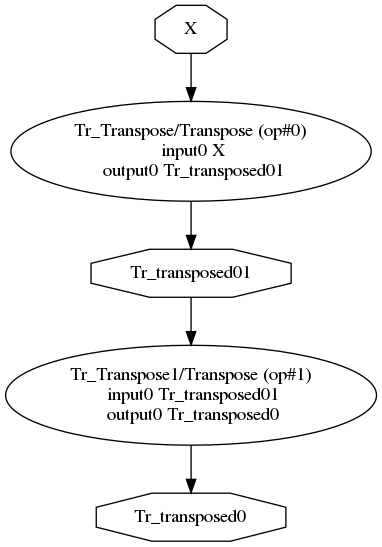

In [5]:
# Load
onnx_model = onnx.load(onnx_file)
model = ModelProto()
with open(onnx_file, 'rb') as fid:
    content = fid.read()
    model.ParseFromString(content)
    
# Make pydot object
pydot_graph = GetPydotGraph(model.graph, name=model.graph.name, rankdir="TB",
                            node_producer=GetOpNodeProducer("docstring"))
graph_file = 'imp_graph.dot'
graph_img = 'imp_graph.png'
pydot_graph.write(graph_file)

# Write image
(graph,) = pydot.graph_from_dot_file(graph_file)
graph.write_png(graph_img)

# View transformation
# # JSON-like
print(onnx_model.__str__())

# # Image
Image(graph_img)

## Make a prediction

In [6]:
def fast_predict(model, *inputs):
    import onnxruntime as rt
    sess = rt.InferenceSession(model.SerializeToString())
    in_names = [i.name for i in sess.get_inputs()]
    in_dict = {name: in_val for name, in_val in zip(in_names, inputs)}
    res = sess.run(None, in_dict)[-1]
    return res

In [9]:
X_2 = np.arange(2 * 3 * 4 * 2).reshape((2, 3, 4 * 2)).astype(np.float32)

In [10]:
fast_predict(model_custom, X_2)

array([[[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.],
        [16., 17., 18., 19., 20., 21., 22., 23.]],

       [[24., 25., 26., 27., 28., 29., 30., 31.],
        [32., 33., 34., 35., 36., 37., 38., 39.],
        [40., 41., 42., 43., 44., 45., 46., 47.]]], dtype=float32)

## Get detailled information on the prediction

In [8]:
def detailed_predict(model, *inputs):
    import onnxruntime as rt
    sess = rt.InferenceSession(model.SerializeToString())
    in_names = [i.name for i in sess.get_inputs()]
    print("1")
    print(in_names)
    in_dict = {name: in_val for name, in_val in zip(in_names, inputs)}
    print("2")
    print(in_dict)
    res = sess.run(None, in_dict)
    print("3")
    print(res)
    out_names = [o.name for o in sess.get_outputs()]
    print("4")
    print(out_names)
    print("5")
    return {name: output for name, output in zip(out_names, res)}

Y = detailed_predict(model_custom, X)
print(Y)

1
['X']
2
{'X': array([[[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]],

       [[12., 13., 14., 15.],
        [16., 17., 18., 19.],
        [20., 21., 22., 23.]]], dtype=float32)}
3
[array([[[ 0.,  1.,  2.,  3.],
        [12., 13., 14., 15.]],

       [[ 4.,  5.,  6.,  7.],
        [16., 17., 18., 19.]],

       [[ 8.,  9., 10., 11.],
        [20., 21., 22., 23.]]], dtype=float32), array([[[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]],

       [[12., 13., 14., 15.],
        [16., 17., 18., 19.],
        [20., 21., 22., 23.]]], dtype=float32)]
4
['Tr_transposed01', 'Tr_transposed0']
5
{'Tr_transposed01': array([[[ 0.,  1.,  2.,  3.],
        [12., 13., 14., 15.]],

       [[ 4.,  5.,  6.,  7.],
        [16., 17., 18., 19.]],

       [[ 8.,  9., 10., 11.],
        [20., 21., 22., 23.]]], dtype=float32), 'Tr_transposed0': array([[[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]],

     

---

# End of script